# Working with Metadata

In order to work with complex dataset structures you will need to pass 
additional information about you data to SDV using `Metadata`.

Let's go over an example to see how to use it.

## Load the demo data

In order to follow this tutorial you will need to load one of the demo
datasets included in SDV by calling the `sdv.load_demo` function.

In [1]:
# Setup logging and warnings
import logging;
logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(level=logging.WARNING)
logging.getLogger('sdv').setLevel(level=logging.INFO)

import warnings
warnings.simplefilter("ignore")

In [2]:
from sdv import load_demo

tables = load_demo()

The output of this function will be a dict that contains several
tables as `pandas.DataFarmes`.

In [3]:
tables.keys()

dict_keys(['users', 'sessions', 'transactions'])

In [4]:
from sdv.utils import display_tables

display_tables(tables)

You can observe that this dataset has the following structure:

* A `users` table with:
    * A `user_id` field with acts as the table primary key.
    * Two categorical fields, `country` and `gender`, and an integer column `age`.
* A `sessions` table with:
    * A `session_id` field with acts as the table primary key.
    * A `user_id` field which is a foreign key to the `users` table and defines
      a One-to-Many relationship with it (one `user` can have many `sessions`).
    * Two categorical fields `device` and `os`.
* A `transactions` table with:
    * A `transaction_id` field with acts as the table primary key.
    * A `session_id` field which is a foreign key to the `sessions` table and
      defines a One-to-Many relationship with it (one `user` can make many
      `transactions` within a single `session`).
    * A datetime field, `timestamp`.
    * A float field, `amount`.
    * A boolean field, `approved`.
    
Let us now see how to build a `Metadata` object that represents this dataset.

## The Metadata class

In SDV, the structure of a dataset is represented using the class
`sdv.Metadata`, which contains all the information that SDV needs in
order to optimally learn the dataset and generate synthetic versions
of it.

In order to create a `Metadata` for our dataset, you will first need to
import the class and create an empty instance:

In [5]:
from sdv import Metadata

metadata = Metadata()
metadata

Metadata
  root_path: .
  tables: []
  relationships:

## Add a Table

Once you have your `Metadata` instance ready you can start adding
tables.

In this example, you will add the table `users`, which is the parent
table of your dataset, indicating which is its Primary Key field,
`user_id`.

Note that indicating the Primary Key is optional and can be skipped
if your table has none, but if a table does not have one, you will not
be able to add any child tables to it.

In [6]:
metadata.add_table(
    name='users',
    data=tables['users'],
    primary_key='user_id'
)

At this point, our metadata only contains one table and, of course,
no relationships:

In [7]:
metadata

Metadata
  root_path: .
  tables: ['users']
  relationships:

However, the `Metadata` instance will have already analyze all the
columns in the passed table and identified the different data types
and subtypes, and will properly indicate that the `user_id` column
is the table primary key.

You can see so by calling the `visualize` method of your `metadata`
instance:

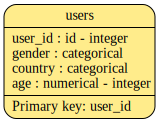

In [8]:
metadata.visualize()

Or you can obtain this information in a machine-readable format by
calling the `get_table_meta` method:

In [9]:
metadata.get_table_meta('users')

{'fields': {'user_id': {'type': 'id', 'subtype': 'integer'},
  'gender': {'type': 'categorical'},
  'country': {'type': 'categorical'},
  'age': {'type': 'numerical', 'subtype': 'integer'}},
 'primary_key': 'user_id'}

## Add a Child Table

Now that you have one parent table, you will add its child table
`sessions`, which is related to the `users` table in a parent-child
relationship where each `user` can have multiple `sessions`, and
each `session` belongs to one and only one `user`.

In order to specify this, while creating the `sessions` table you have
to indicate the name of the parent table, `users`, and the field from
the `sessions` table that acts as the foreign key, which in this
case is called `user_id`.

With this, apart from analyzing all the columns and indicating the
primary key like in the previous step, the `Metadata` instance will
specify a relationship between the two tables by adding a property to
the `user_id` field that indicates that it is related to the `user_id`
field in the `users` table.

In [10]:
metadata.add_table(
    name='sessions',
    data=tables['sessions'],
    primary_key='session_id',
    parent='users',
    foreign_key='user_id'
)

Now we can see how the table and the relationship have been registered:

In [11]:
metadata

Metadata
  root_path: .
  tables: ['users', 'sessions']
  relationships:
    sessions.user_id -> users.user_id

### Add a table specifying field properties

There are situations where the `Metadata` analysis is not able to figure
out some data types or subtypes, or to deduce some properties of the
field such as the datetime format.

In these situations, you can pass a dictionary with the exact metadata
of those fields, which will overwrite the deductions from the analysis
process.

In this next example, you will be adding a `transactions` table, which
is related to the previous `sessions` table, and contains a `datetime`
field which needs to have the datetime format specified.

In [12]:
transactions_fields = {
    'timestamp': {
        'type': 'datetime',
        'format': '%Y-%m-%d'
    }
}

metadata.add_table(
    name='transactions',
    data=tables['transactions'],
    fields_metadata=transactions_fields,
    primary_key='transaction_id',
    parent='sessions'
)

Let's see what our Metadata looks like right now:

In [13]:
metadata

Metadata
  root_path: .
  tables: ['users', 'sessions', 'transactions']
  relationships:
    sessions.user_id -> users.user_id
    transactions.session_id -> sessions.session_id

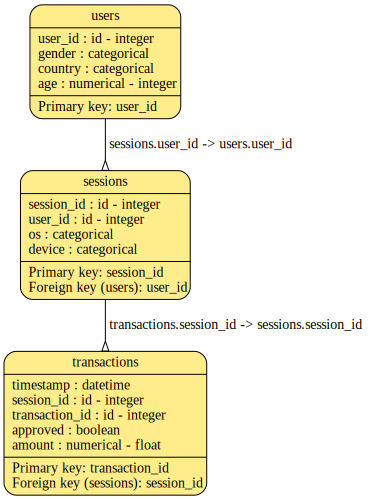

In [14]:
metadata.visualize()

In [15]:
metadata.to_dict()

{'tables': {'users': {'fields': {'user_id': {'type': 'id',
     'subtype': 'integer'},
    'gender': {'type': 'categorical'},
    'country': {'type': 'categorical'},
    'age': {'type': 'numerical', 'subtype': 'integer'}},
   'primary_key': 'user_id'},
  'sessions': {'fields': {'session_id': {'type': 'id', 'subtype': 'integer'},
    'user_id': {'type': 'id',
     'subtype': 'integer',
     'ref': {'table': 'users', 'field': 'user_id'}},
    'os': {'type': 'categorical'},
    'device': {'type': 'categorical'}},
   'primary_key': 'session_id'},
  'transactions': {'fields': {'timestamp': {'type': 'datetime',
     'format': '%Y-%m-%d'},
    'session_id': {'type': 'id',
     'subtype': 'integer',
     'ref': {'table': 'sessions', 'field': 'session_id'}},
    'transaction_id': {'type': 'id', 'subtype': 'integer'},
    'approved': {'type': 'boolean'},
    'amount': {'type': 'numerical', 'subtype': 'float'}},
   'primary_key': 'transaction_id'}}}

## Metadata JSON format

The `Metadata` objects can also be saved as a JSON file and later on loaded from them.

In order to save the current `metadata` as a JSON file, all you need to do is call the
`to_json` method passing the path to the JSON file that you want to create.

In [16]:
metadata.to_json('demo_metadata.json')

You can see that the contents of the created file are very similar to the
`dict` representation of the metadata:

In [17]:
with open('demo_metadata.json') as meta_file:
    print(meta_file.read())

{
    "tables": {
        "users": {
            "fields": {
                "user_id": {
                    "type": "id",
                    "subtype": "integer"
                },
                "gender": {
                    "type": "categorical"
                },
                "country": {
                    "type": "categorical"
                },
                "age": {
                    "type": "numerical",
                    "subtype": "integer"
                }
            },
            "primary_key": "user_id"
        },
        "sessions": {
            "fields": {
                "session_id": {
                    "type": "id",
                    "subtype": "integer"
                },
                "user_id": {
                    "type": "id",
                    "subtype": "integer",
                    "ref": {
                        "table": "users",
                        "field": "user_id"
                    }
                },
                "

After creating the JSON file, loading it back as a `metadata` object
is as simple as passing it to the `Metadata` constructor:

In [18]:
loaded = Metadata('demo_metadata.json')
loaded

Metadata
  root_path: 
  tables: ['users', 'sessions', 'transactions']
  relationships:
    sessions.user_id -> users.user_id
    transactions.session_id -> sessions.session_id